In [1]:
import sklearn
from sklearn.cluster import KMeans
# !pip install scikit-image
from skimage.io import imread
import pylab
import skimage
# %matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Загрузите картинку parrots.jpg. 
Преобразуйте изображение, приведя все значения в интервал от 0 до 1. Для этого можно воспользоваться функцией img_as_float из модуля skimage. Обратите внимание на этот шаг, так как при работе с исходным изображением вы получите некорректный результат

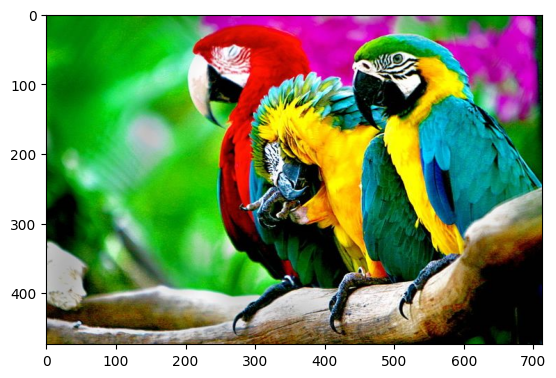

In [2]:
image = imread('14-statement-clustering/parrots.jpg')
pylab.imshow(image)
image01 = skimage.img_as_float(image)

# pylab.imshow(image01)

## 2. Создайте матрицу объекты-признаки: характеризуйте каждый пиксель тремя координатами- значениями интенсивности в пространстве RGB

In [3]:
image01
matrix = pd.DataFrame(image01.reshape(-1, 3)[:, :3], columns=['R', 'G', 'B'])
matrix.head()

,R,G,B
0,0.015686,0.494118,0.019608
1,0.011765,0.490196,0.015686
2,0.007843,0.494118,0.007843
3,0.007843,0.494118,0.007843
4,0.007843,0.501961,0.011765


##  3. Запустите алгоритм K-Means с параметрами init=’k-means++’ и random_state=241. 
После выделения кластеров все пиксели, отнесенные в один кластер, попробуйте заполнить двумя способами: медианным и средним цветом по кластеру

In [4]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=241)
image01_r = image01.reshape(-1, 3)
labels = kmeans.fit_predict(image01_r)
labels

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

In [30]:
# Средние цвета по каждому кластеру
means = np.zeros((kmeans.n_clusters, 3), dtype=np.float32)

for i in range(kmeans.n_clusters):
    means[i] = np.mean(image01_r[labels == i], axis=0)

mean_result = means[labels].reshape(image.shape)

In [31]:
# Медианные цвета по каждому кластеру
medians = np.zeros((kmeans.n_clusters, 3), dtype=np.float32)

for i in range(kmeans.n_clusters):
    medians[i] = np.median(image01_r[labels == i], axis=0)

median_result = medians[labels].reshape(image.shape)

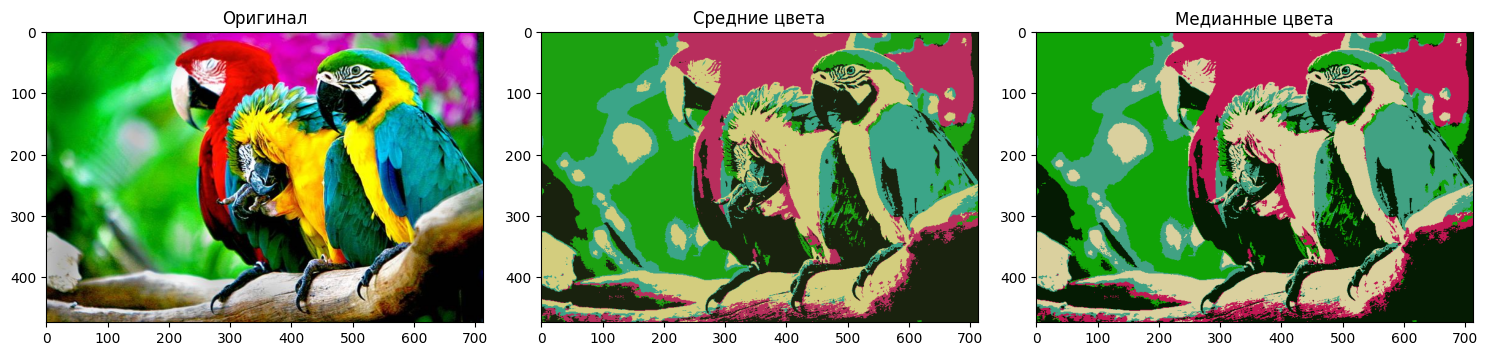

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image)
axs[0].set_title('Оригинал')

axs[1].imshow(mean_result)
axs[1].set_title('Средние цвета')

axs[2].imshow(median_result)
axs[2].set_title('Медианные цвета')

plt.tight_layout()
plt.show()

## 4. Измерьте качество получившейся сегментации с помощью метрики PSNR. 
Эту метрику нужно реализовать самостоятельно (см. определение).

In [34]:
import numpy as np

def compute_psnr(original, compressed):
    original = original.astype(np.float32)
    compressed = compressed.astype(np.float32)
    
    mse = np.mean((original - compressed) ** 2)
    
    if mse == 0:
        return float('inf')  # в таком случае изображение одинаковые, будет деление на ноль

    PIXEL_MAX = 1.0
    psnr = 10 * np.log10((PIXEL_MAX ** 2) / mse)
    return psnr


In [35]:
psnr_mean = compute_psnr(image01, mean_result)
psnr_median = compute_psnr(image01, median_result)

print(f'PSNR для средних цветов: {psnr_mean:.2f} дБ')
print(f'PSNR для медианных цветов: {psnr_median:.2f} дБ')


PSNR для средних цветов: 15.09 дБ
PSNR для медианных цветов: 14.69 дБ


## 5. Найдите минимальное количество кластеров, при котором значение PSNR выше 20 
(можно рассмотреть не более 20 кластеров, но не забудьте рассмотреть оба способа заполнения пикселей одного кластера). Это число и будет ответом в данной задаче

In [36]:
psnr_means = []
psnr_medians = []

# Перебор кластеров
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=241, n_init='auto')
    labels = kmeans.fit_predict(image01_r)
    
    means = np.zeros((k, 3), dtype=np.float32)
    medians = np.zeros((k, 3), dtype=np.float32)

    for i in range(k):
        cluster_pixels = image01_r[labels == i]
        means[i] = np.mean(cluster_pixels, axis=0)
        medians[i] = np.median(cluster_pixels, axis=0)

    mean_result = means[labels].reshape(image01.shape)
    median_result = medians[labels].reshape(image01.shape)

    psnr_mean = compute_psnr(image01, mean_result)
    psnr_median = compute_psnr(image01, median_result)

    if psnr_means > 20 or psnr_m
    psnr_means.append(psnr_mean)
    psnr_medians.append(psnr_median)

    print(f"k={k:2d} | PSNR (mean): {psnr_mean:.2f} дБ | PSNR (median): {psnr_median:.2f} дБ")

# Поиск минимального k
for k, (p_mean, p_median) in enumerate(zip(psnr_means, psnr_medians), start=1):
    if p_mean > 20 or p_median > 20:
        print(f"\nМинимальное k, при котором PSNR > 20 дБ: {k}")
        break

k= 1 | PSNR (mean): 9.84 дБ | PSNR (median): 9.46 дБ
k= 2 | PSNR (mean): 12.11 дБ | PSNR (median): 11.69 дБ
k= 3 | PSNR (mean): 13.17 дБ | PSNR (median): 12.63 дБ
k= 4 | PSNR (mean): 14.32 дБ | PSNR (median): 14.00 дБ
k= 5 | PSNR (mean): 15.09 дБ | PSNR (median): 14.69 дБ
k= 6 | PSNR (mean): 16.57 дБ | PSNR (median): 16.07 дБ
k= 7 | PSNR (mean): 17.67 дБ | PSNR (median): 17.37 дБ
k= 8 | PSNR (mean): 18.38 дБ | PSNR (median): 18.10 дБ
k= 9 | PSNR (mean): 19.14 дБ | PSNR (median): 18.84 дБ
k=10 | PSNR (mean): 19.54 дБ | PSNR (median): 19.23 дБ
k=11 | PSNR (mean): 20.08 дБ | PSNR (median): 19.83 дБ
k=12 | PSNR (mean): 20.58 дБ | PSNR (median): 20.32 дБ
k=13 | PSNR (mean): 21.06 дБ | PSNR (median): 20.83 дБ
k=14 | PSNR (mean): 21.37 дБ | PSNR (median): 21.16 дБ
k=15 | PSNR (mean): 21.65 дБ | PSNR (median): 21.45 дБ
k=16 | PSNR (mean): 21.89 дБ | PSNR (median): 21.70 дБ
k=17 | PSNR (mean): 22.15 дБ | PSNR (median): 21.96 дБ
k=18 | PSNR (mean): 22.38 дБ | PSNR (median): 22.18 дБ
k=19 | PSNR 